https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import vgg16
import os
from random import shuffle
from glob import glob
%matplotlib inline
from matplotlib import pyplot as plt
import re
from sklearn.metrics import log_loss

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
!cp /gdrive/'MyDrive'/'Компьютерное зрение'/test.zip .

In [4]:
!cp /gdrive/'MyDrive'/'Компьютерное зрение'/train.zip .

In [ ]:
!unzip test.zip
!unzip train.zip

In [6]:
IMG_SIZE = (224, 224)

train_files = glob('/content/train/*.jpg')
test_files = glob('/content/test/*.jpg')

def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)

def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

In [7]:
len(train_files), len(test_files)

(25000, 12500)

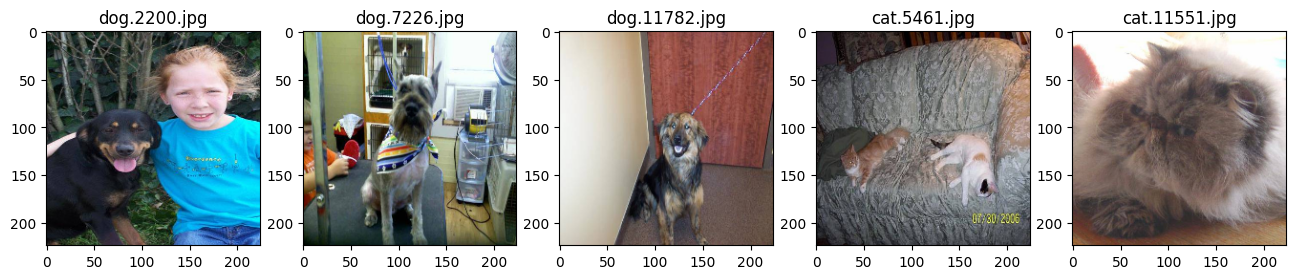

In [8]:
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:5], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

In [9]:
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

58889256/58889256 [==============================] - 4s 0us/step


In [10]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
'''Можно поменять функцию потерь на categorical_crossentropy например. Также эффективно менять оптимизатор.
Например можно рассмотреть optimizers.SGD(lr = 0.001, momentum = 0.1, decay = 0.0). Хорошо еще слой докинуть,
например tf.keras.layers.Dense(256, activation=‘relu’)(x) и tf.keras.layers.BatchNormalization()(x).
Попробуйте улучшить результат модели, не обязательно использовать все то, о чем я написала, предложите свои варианты. Метрику также считайте на кегле.'''

In [22]:
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [23]:
model.summary()

Model: "dogs_vs_cats"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

In [25]:
optim = tf.keras.optimizers.SGD(learning_rate = 0.005, momentum = 0.9, weight_decay = 0.0)
model.compile(optimizer=optim,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
val_samples = 2500

shuffle(train_files)
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])

model.fit(train_data,
          steps_per_epoch=10,
          epochs=100,
          validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 17s 2s/step - loss: 0.7700 - accuracy: 0.5656 - val_loss: 3.5936 - val_accuracy: 0.5008
Epoch 2/100
10/10 [==============================] - 12s 1s/step - loss: 0.6684 - accuracy: 0.6719 - val_loss: 1.7526 - val_accuracy: 0.5020
Epoch 3/100
10/10 [==============================] - 12s 1s/step - loss: 0.6866 - accuracy: 0.6313 - val_loss: 0.5269 - val_accuracy: 0.7284
Epoch 4/100
10/10 [==============================] - 12s 1s/step - loss: 0.6068 - accuracy: 0.6969 - val_loss: 0.5482 - val_accuracy: 0.7384
Epoch 5/100
10/10 [==============================] - 12s 1s/step - loss: 0.5256 - accuracy: 0.7594 - val_loss: 0.4743 - val_accuracy: 0.7828
Epoch 6/100
10/10 [==============================] - 12s 1s/step - loss: 0.4646 - accuracy: 0.7625 - val_loss: 0.3303 - val_accuracy: 0.8500
Epoch 7/100
10/10 [==============================] - 12s 1s/step - loss: 0.4469 - accuracy: 0.7937 - val_loss: 0.2961 - val_accuracy: 0.8752
Epoch 8/100
1

In [27]:
model.save('cats-dogs-vgg16.hdf5')

In [28]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

print(np.argmax(test_pred))

12500/12500 [==============================] - 120s 10ms/step
42


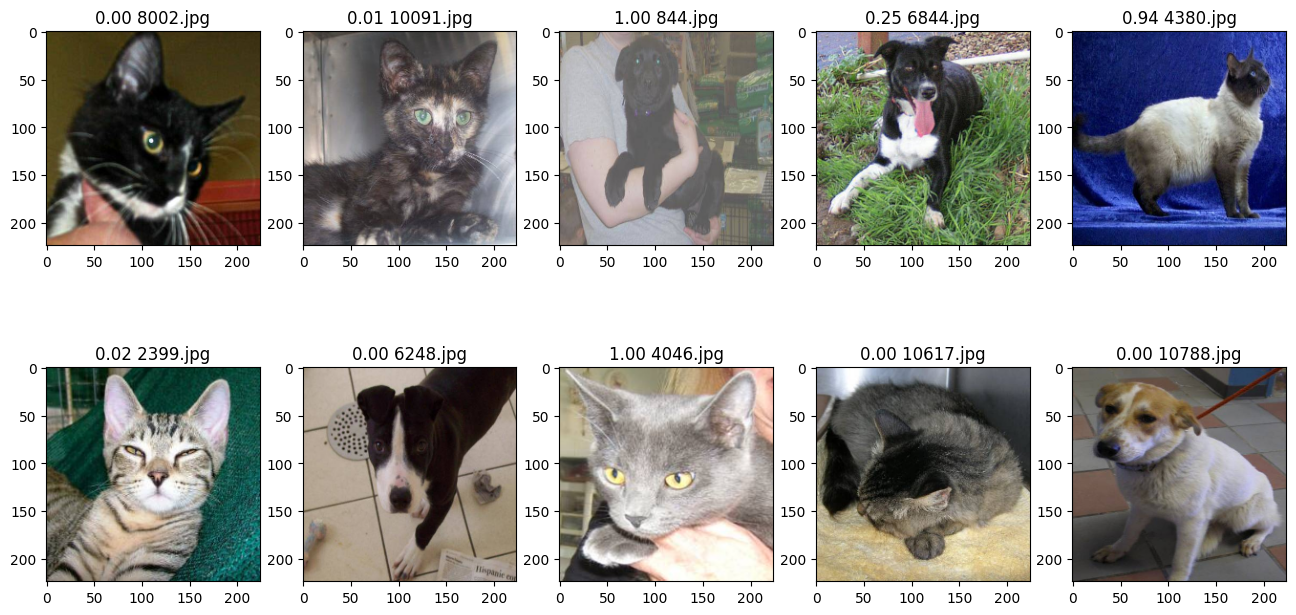

In [29]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[1000:1010], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

In [30]:
with open('submit.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

In [31]:
sub = pd.read_csv('submit.csv')
sub

,id,label
0,9971,0.000109
1,4236,0.010539
2,4691,0.999097
3,12247,0.247065
4,9932,0.935204
...,...,...
12495,8796,0.998029
12496,11331,0.991735
12497,7321,0.999743
12498,9776,0.285947
